# House Price Prediction
Group Name:Ask Poe

LAI Ka Chung

LI Chun Yin

Refernece :

https://www.kaggle.com/code/keithfish/kaggle-7-xgbst-enet/script#L248

Install library needed

!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost

# Import Library

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# Import data

In [2]:
train_file_path = '../input/house-prices-advanced-regression-techniques/train.csv'
test_file_path = '../input/house-prices-advanced-regression-techniques/test.csv'
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)
# Save IDs for submission
train_ID = train['Id']
test_ID = test['Id']
# Drop Id since it is unnecressary for prediction process
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Data exploration

In [3]:
# Create copy of dataset
df_train_copy = train.copy()

In [4]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Check the percentage of missing values

In [5]:
# Check missing percentage for all columns
missing_percentages = (df_train_copy.isnull().sum() / len(df_train_copy)) * 100

# If you want to separate by data types:
object_cols = df_train_copy.select_dtypes(include=['object']).columns
numeric_cols = df_train_copy.select_dtypes(include=['int64', 'float64']).columns

# For object (categorical) columns only
object_missing = (df_train_copy[object_cols].isnull().sum() / len(df_train_copy)) * 100

# For numeric columns only
numeric_missing = (df_train_copy[numeric_cols].isnull().sum() / len(df_train_copy)) * 100

# Print in a nice format
print("Missing Percentages in Categorical Columns:")
print(object_missing[object_missing > 0].sort_values(ascending=False))
print("\nMissing Percentages in Numerical Columns:")
print(numeric_missing[numeric_missing > 0].sort_values(ascending=False))

Missing Percentages in Categorical Columns:
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
GarageFinish     5.547945
GarageQual       5.547945
GarageType       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtFinType1     2.534247
BsmtCond         2.534247
Electrical       0.068493
dtype: float64

Missing Percentages in Numerical Columns:
LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64


HeatMap (show the relationship bewteen attutiube and salesprice)

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

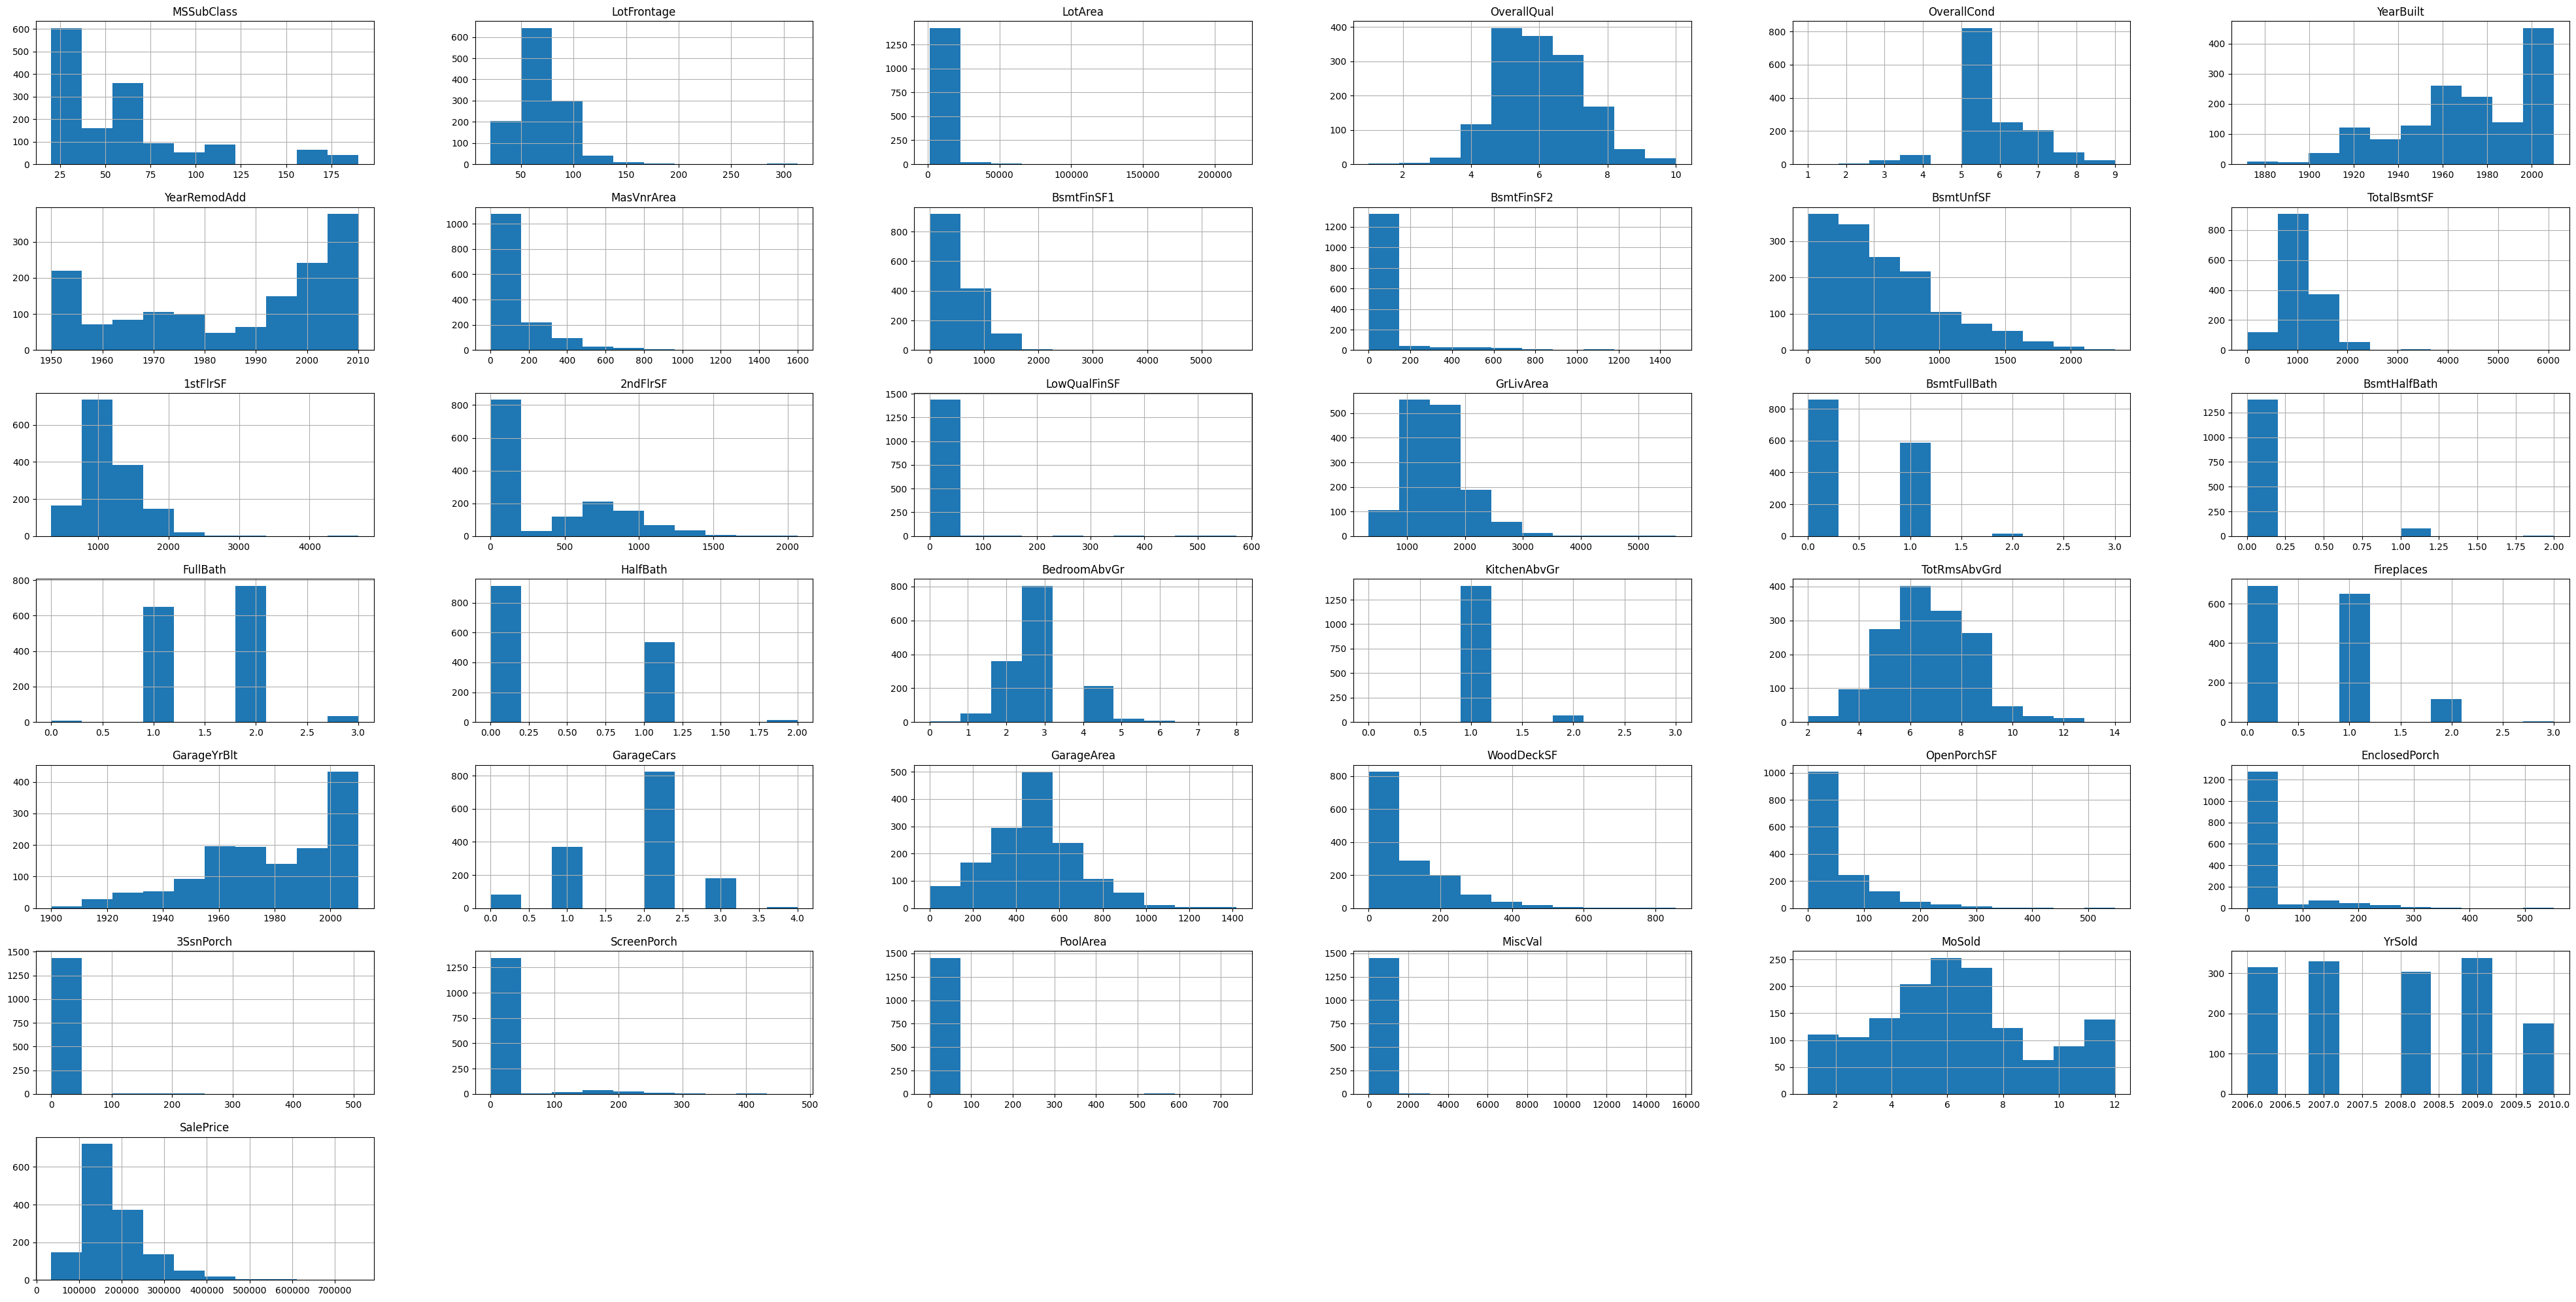

In [6]:
df_train_copy.hist(figsize=(50, 25))

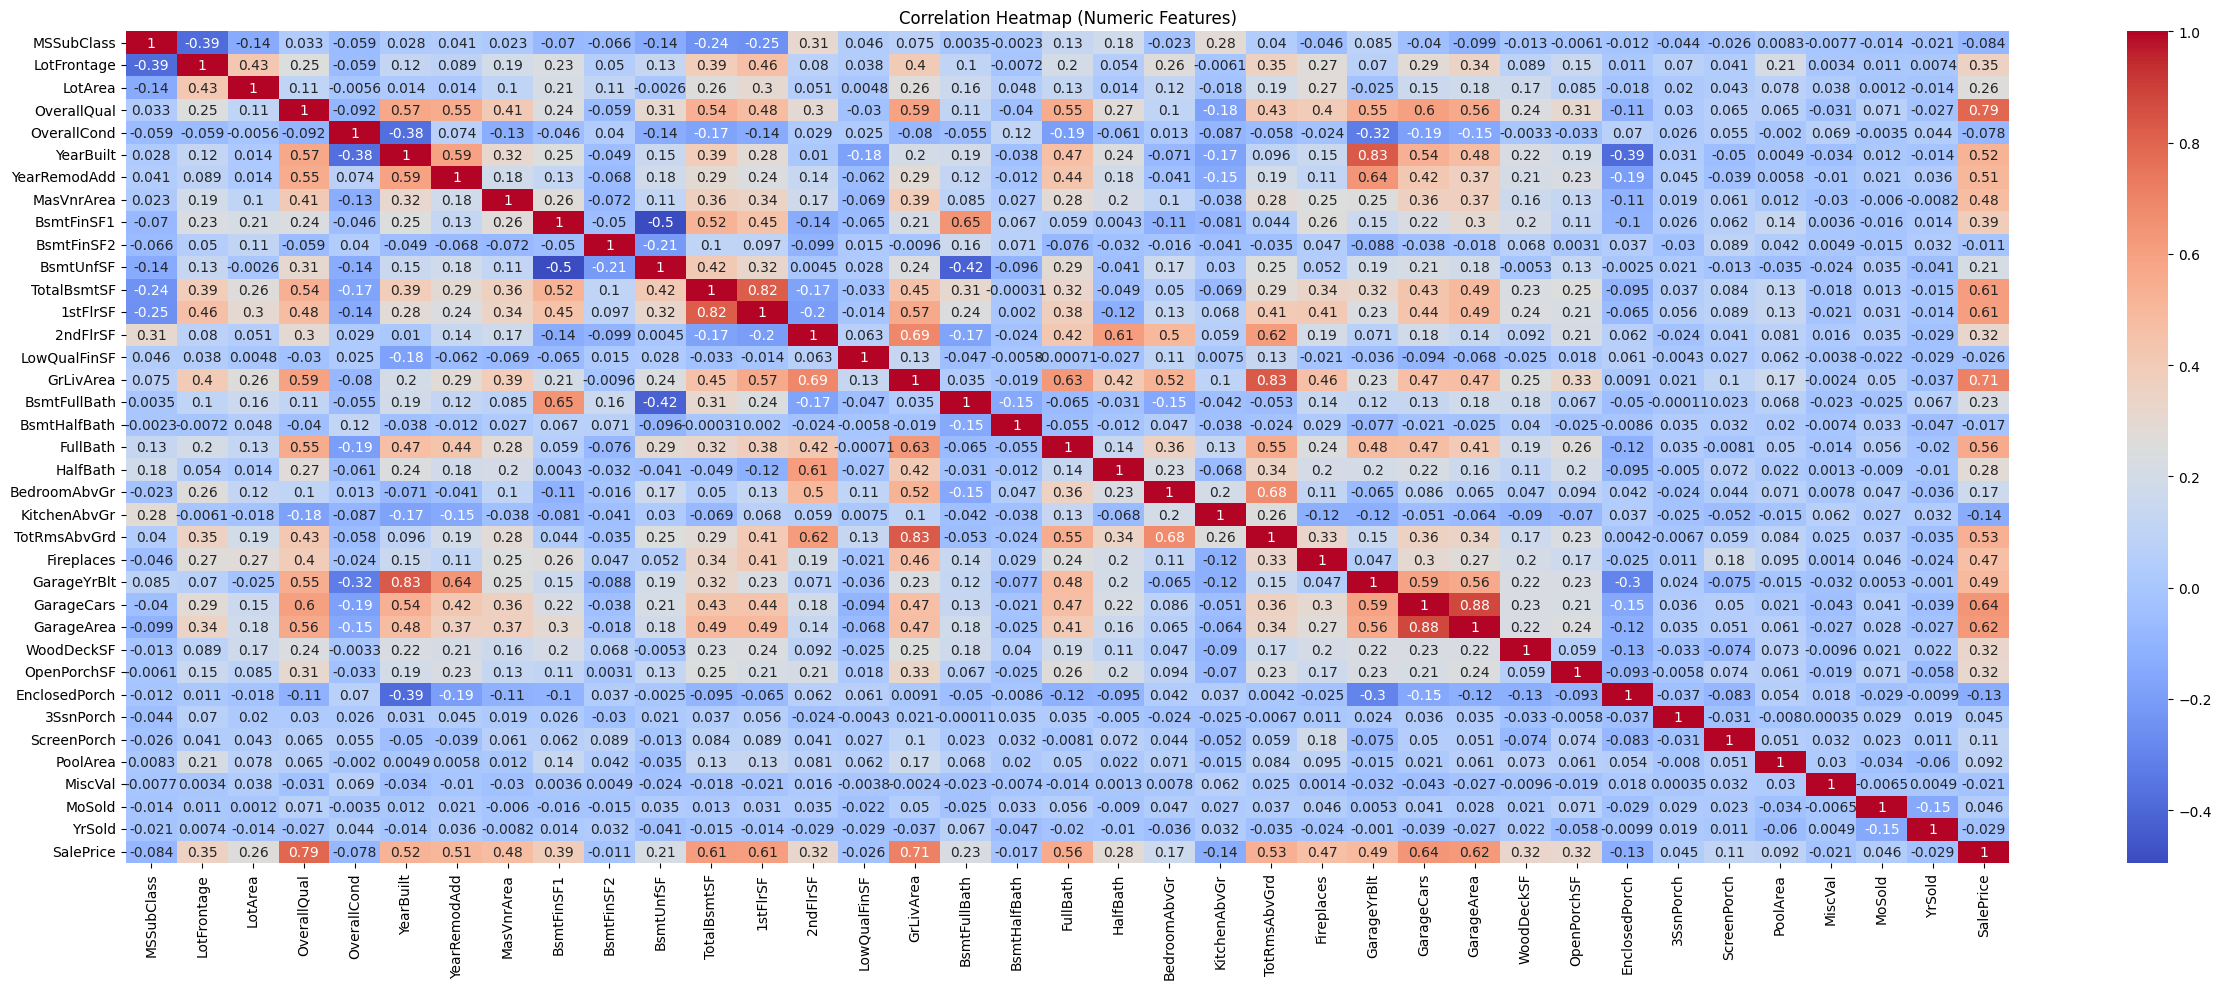

In [7]:
# Select only numeric columns
numeric_cols = df_train_copy.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df_train_copy[numeric_cols]

plt.figure(figsize=(25, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

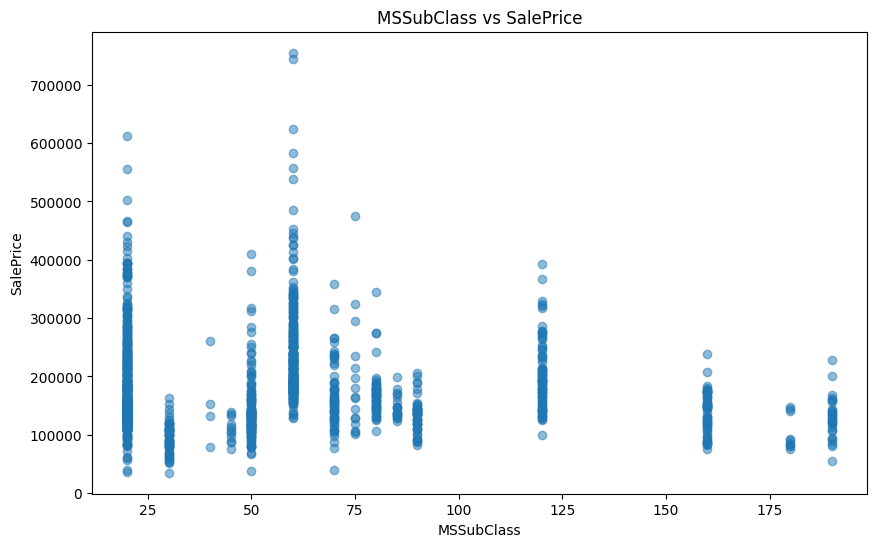

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train_copy['MSSubClass'], df_train_copy['SalePrice'], alpha=0.5)
plt.xlabel('MSSubClass')
plt.ylabel('SalePrice')
plt.title('MSSubClass vs SalePrice')
plt.show()

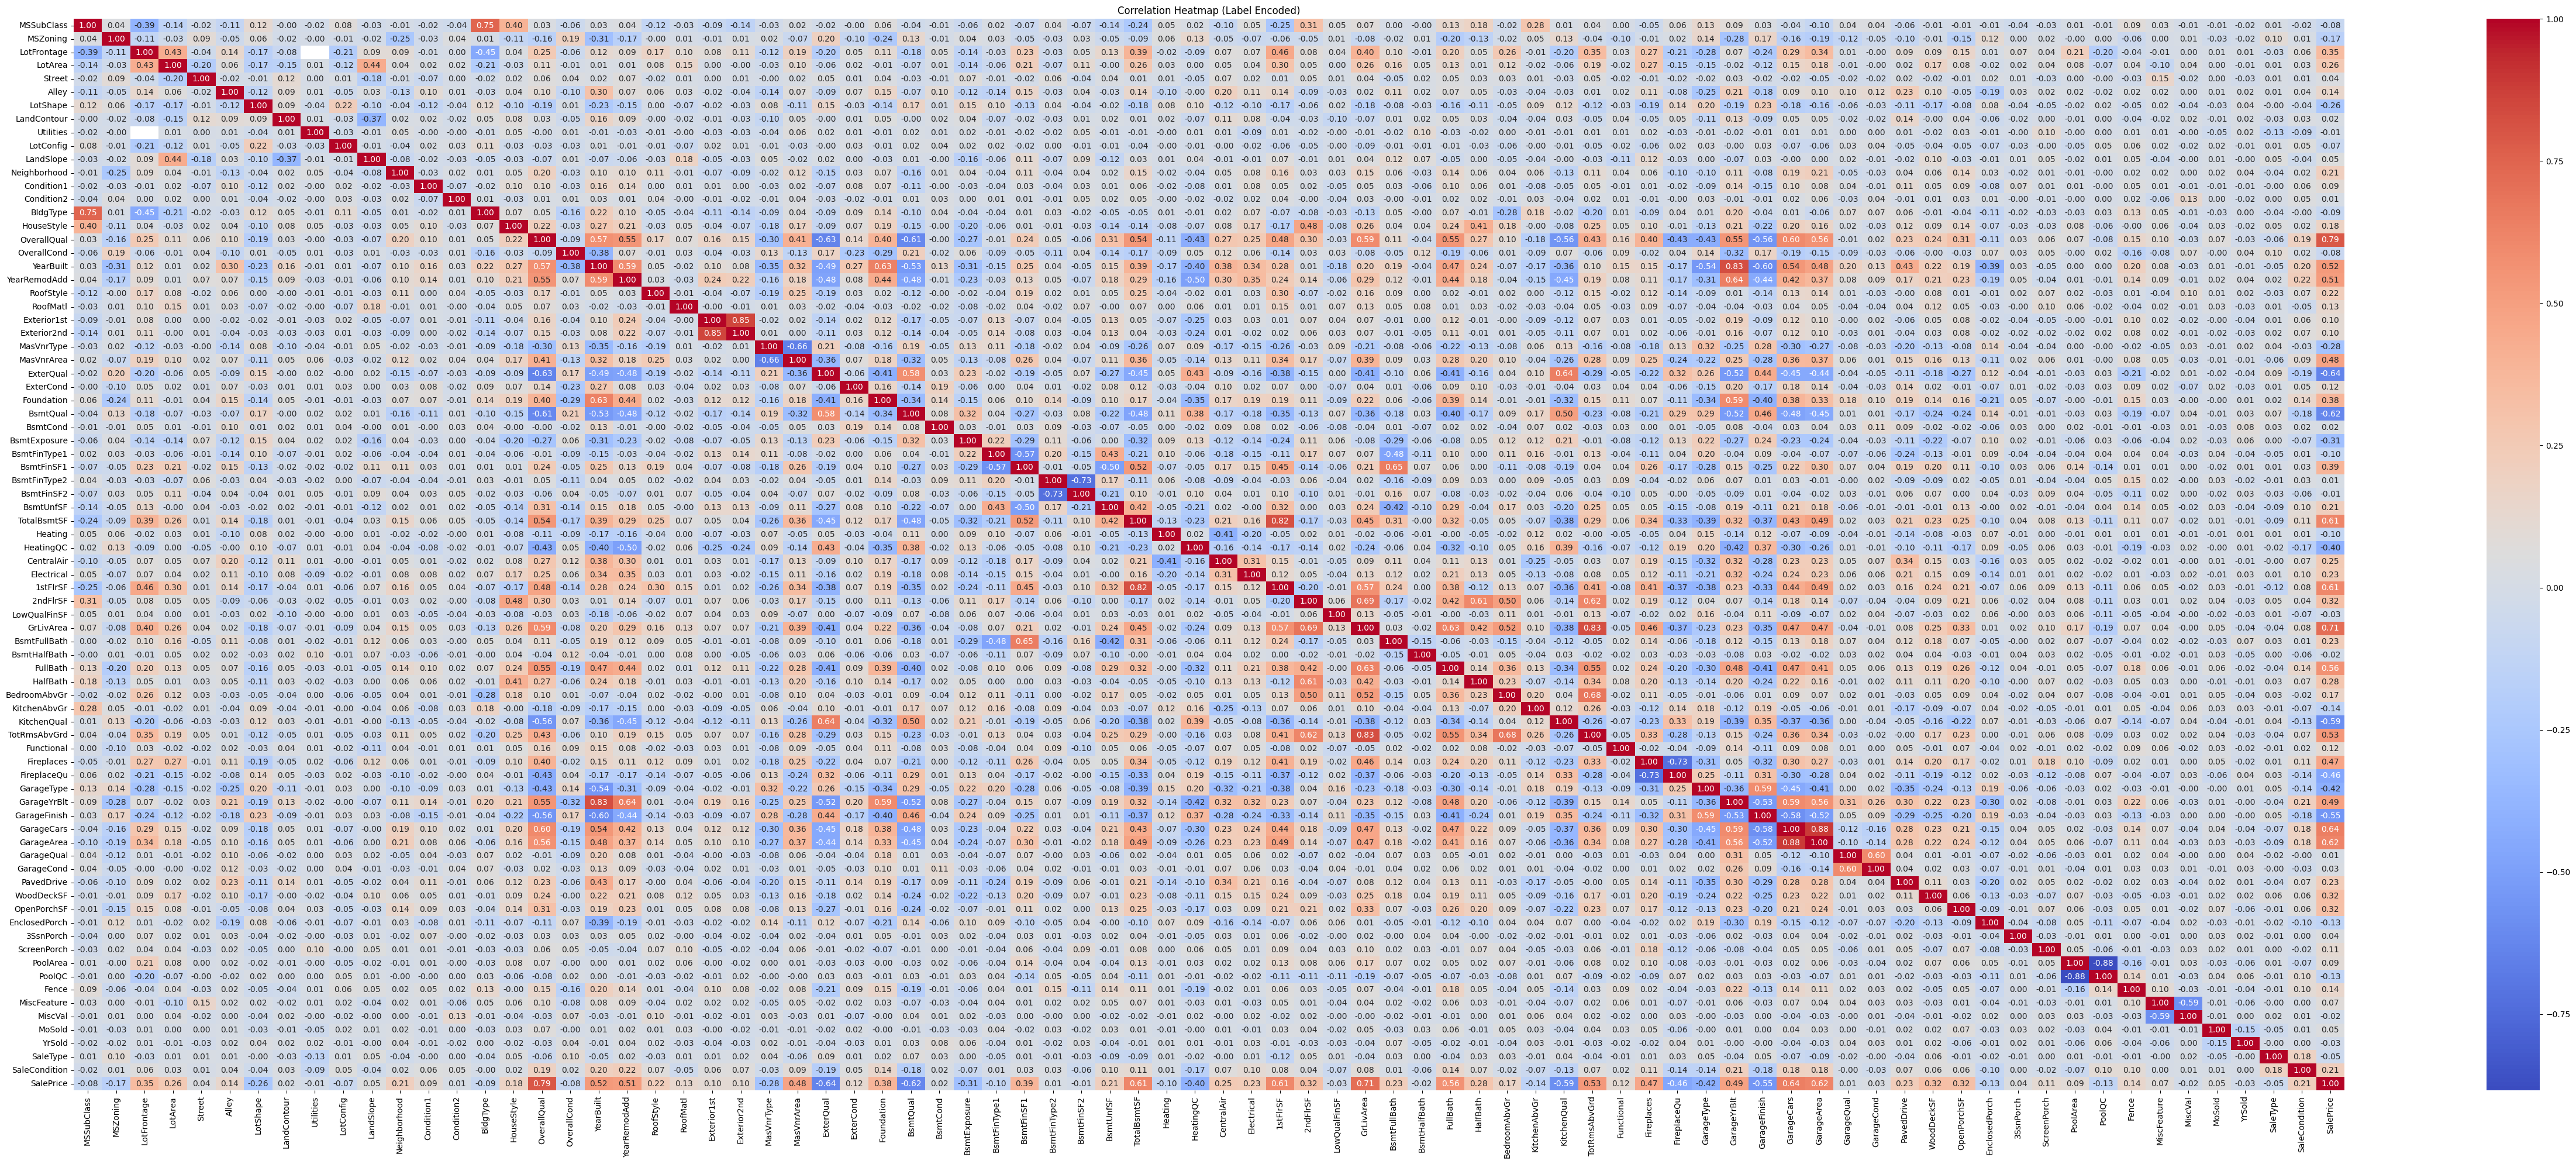

In [9]:
from sklearn.preprocessing import LabelEncoder

# Create copy of dataset
df_encoded = df_train_copy.copy()

# Get categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(train[col].astype(str))
    
corr_matrix =df_encoded.corr()
# Create heatmap
plt.figure(figsize=(50, 20))
sns.heatmap(corr_matrix, 
            annot=True,           
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation Heatmap (Label Encoded)')
plt.tight_layout()
plt.show()

In [10]:
# Get upper triangle of correlation matrix
def get_high_correlations(corr_matrix, threshold=0.7):
    corr_pairs = []
    upper_tri = np.triu(corr_matrix, k=1)
    rows, cols = np.where(np.abs(upper_tri) > threshold)
    
    for i, j in zip(rows, cols):
        corr = corr_matrix.iloc[i, j]
        feat1 = corr_matrix.index[i]
        feat2 = corr_matrix.columns[j]
        corr_pairs.append((feat1, feat2, corr))
    
    return pd.DataFrame(corr_pairs, 
                       columns=['Feature1', 'Feature2', 'Correlation'])\
             .sort_values('Correlation', ascending=False)

high_corr = get_high_correlations(corr_matrix)
print(high_corr)

        Feature1      Feature2  Correlation
9     GarageCars    GarageArea     0.882475
3    Exterior1st   Exterior2nd     0.854163
2      YearBuilt   GarageYrBlt     0.825667
6      GrLivArea  TotRmsAbvGrd     0.825489
5    TotalBsmtSF      1stFlrSF     0.819530
1    OverallQual     SalePrice     0.790982
0     MSSubClass      BldgType     0.746063
7      GrLivArea     SalePrice     0.708624
8     Fireplaces   FireplaceQu    -0.728289
4   BsmtFinType2    BsmtFinSF2    -0.728928
10      PoolArea        PoolQC    -0.884250


# Data Preprocessing

In [11]:
# Log transform the target variable
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)

# Separate features
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [12]:


# Combine features for preprocessing
features = pd.concat([train_features, test_features]).reset_index(drop=True)

# Turn non-numeric predictors into strings
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Fill 0 or 'None' for missing features indicating absence
features['PoolQC'] = features['PoolQC'].fillna("None")
features['MiscFeature'] = features['MiscFeature'].fillna("None")
features['Fence'] = features['Fence'].fillna("None")
features['Alley'] = features['Alley'].fillna("None")
features['FireplaceQu'] = features['FireplaceQu'].fillna("None")

features['GarageFinish'] = features['GarageFinish'].fillna("None")
features['GarageQual'] = features['GarageQual'].fillna("None")
features['GarageType'] = features['GarageType'].fillna("None")
features['GarageCond'] = features['GarageCond'].fillna("None")
features['GarageYrBlt'] = features['GarageYrBlt'].fillna(0)

features['BsmtCond'] = features['BsmtCond'].fillna("None")
features['BsmtFinType1'] = features['BsmtFinType1'].fillna("None")
features['BsmtFinType2'] = features['BsmtFinType2'].fillna("None")
features['BsmtExposure'] = features['BsmtExposure'].fillna("None")
features['BsmtQual'] = features['BsmtQual'].fillna("None")

features['MasVnrArea'] = features['MasVnrArea'].fillna(features['MasVnrArea'].median())
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].median())




# Feature Engineering

In [13]:


# Feature Combine 
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF']=features['BsmtFinSF1'] + features['BsmtFinSF2']+ features ['BsmtUnfSF']+ features['1stFlrSF'] + features['2ndFlrSF']
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])


# Create new features
features['GarageAge'] = features['GarageYrBlt'] - features['YearBuilt']
features['RoomDensity'] = features['TotRmsAbvGrd'] / features['GrLivArea']
features['BasementRatio'] = features['TotalBsmtSF'] / features['1stFlrSF']

# Create interaction features for negative correlations

# Convert categorical to numeric
# For FireplaceQu (typically: Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0)
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
features['FireplaceQu'] = features['FireplaceQu'].map(quality_map)


# For BsmtFinType2 (typically: GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0)
bsmt_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0, np.nan: 0}
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmt_map)

# For PoolQC (similar to FireplaceQu)
features['PoolQC'] = features['PoolQC'].map(quality_map)

# Now create interaction features
features['FireplaceScore'] = features['Fireplaces'] * features['FireplaceQu']
features['BsmtFinScore'] = features['BsmtFinSF2'] * features['BsmtFinType2']
features['PoolScore'] = features['PoolArea'] * features['PoolQC']



In [14]:
# Feature Simplification 
# Simplify MSSubClass
features['HomeStyle'] = features['MSSubClass'].replace({
    20: 'One_Story',
    30: 'One_Story',
    40: 'One_Story',
    45: 'One_Half_Story',
    50: 'One_Half_Story',
    60: 'Two_Story',
    70: 'Two_Story',
    75: 'Two_Half_Story',
    80: 'Split_Level',
    85: 'Split_Level',
    90: 'Duplex',
    120: 'One_Story_PUD',
    150: 'One_Half_Story_PUD',
    160: 'Two_Story_PUD',
    180: 'PUD_Multilevel',
    190: 'Two_Family'
})

# Simplify Neighborhood into zones
high_end = ['NridgHt', 'StoneBr', 'NoRidge']
medium_end = ['CollgCr', 'Veenker', 'Crawfor', 'Somerst', 'Timber']
features['NeighborhoodClass'] = np.select(
    [features['Neighborhood'].isin(high_end),
     features['Neighborhood'].isin(medium_end)],
    ['High', 'Medium'], default='Standard')

# Has features
features['HasGarage'] = (features['GarageArea'] > 0).astype(int)
features['HasFireplace'] = (features['Fireplaces'] > 0).astype(int)
features['HasPool'] = (features['PoolArea'] > 0).astype(int)
features['HasBasement'] = (features['TotalBsmtSF'] > 0).astype(int)

In [15]:
# Drop combined features's original features
to_drop_com = ['Exterior2nd', 'GarageYrBlt', 'TotRmsAbvGrd','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']
features.drop(to_drop_com, axis=1, inplace=True)

# Drop highly correlated features
to_drop_highcorr = ['GarageArea']
features.drop(to_drop_highcorr, axis=1, inplace=True)

# Same value / missing lots of NA
features = features.drop(['PoolQC','Street','Utilities'], axis=1)

In [16]:
# show the features in one hot
final_features = pd.get_dummies(features).reset_index(drop=True)

In [17]:


X = final_features.iloc[:len(y)]
X_submission = final_features.iloc[len(X):]

#print("Before attribute drop:")
#print(X.info())
#X.hist(figsize=(50, 25))
# Handle missing values for columns
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_columns:
    col_median = X[col].median()
    X[col] = X[col].fillna(col_median)
    X_submission[col] = X_submission[col].fillna(col_median)


In [18]:
# delete columns having 99% same value prevent overfitting
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99:
        overfit.append(i)

print("Before attribute drop:")
print('X', X.shape, 'X_submission', X_submission.shape)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_submission = X_submission.drop(overfit, axis=1)

print('Dropped overfit attribute:', overfit)
print("After attribute drop:")
print('X', X.shape, 'X_submission', X_submission.shape)

Before attribute drop:
X (1460, 310) X_submission (1459, 310)
Dropped overfit attribute: ['PoolArea', 'PoolScore', 'HasPool', 'MSSubClass_150', 'MSSubClass_180', 'MSSubClass_40', 'MSSubClass_45', 'MSZoning_C (all)', 'LotShape_IR3', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'ExterQual_Fa', 'ExterCond_Ex', 'ExterCond_Po', 'Foundation_St

In [19]:
# Convert data to float64 for better numerical stability
X = X.astype('float64')
X_submission = X_submission.astype('float64')
y = y.astype('float64')

# Model Build

In [20]:
start_datetime = datetime.now()

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# K-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, model in models.items():
    fold_scores = []
    print(f"\nTraining {model_name}:")
    
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X)):
        try:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            # Convert to DataFrame to maintain column names
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
            
            # Train model
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            
            # Convert predictions back to original scale with safeguards
            y_pred_original = np.expm1(y_pred.astype(np.float64))
            y_val_original = np.expm1(y_val.astype(np.float64))
            
            # Clip values to prevent extreme outliers
            max_value = 1e8  # Adjust this threshold based on your data
            y_pred_original = np.clip(y_pred_original, 0, max_value)
            y_val_original = np.clip(y_val_original, 0, max_value)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
            r2 = r2_score(y_val_original, y_pred_original)
            
            fold_scores.append((rmse, r2))
            print(f'Fold {fold+1} - RMSE: {rmse:.2f} - R2: {r2:.4f}')
            
        except Exception as e:
            print(f"Error in fold {fold+1}: {str(e)}")
            continue
    
    if fold_scores:
        avg_rmse = np.mean([score[0] for score in fold_scores])
        avg_r2 = np.mean([score[1] for score in fold_scores])
        results[model_name] = {'RMSE': avg_rmse, 'R2': avg_r2}
        print(f'Average - RMSE: {avg_rmse:.2f} - R2: {avg_r2:.4f}')

# Find and train best model
if results:
    best_model_name = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
    best_model = models[best_model_name]
    
    # Scale full training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Train best model on full dataset
    best_model.fit(X_scaled, y)
    
    # Prepare test data - ensure it has the same columns as training data
    # First, verify the columns match
    missing_cols = set(X.columns) - set(X_submission.columns)
    extra_cols = set(X_submission.columns) - set(X.columns)
    
    if missing_cols:
        # Add missing columns with zeros
        for col in missing_cols:
            X_submission[col] = 0
            
    # Reorder columns to match training data
    X_submission = X_submission[X.columns]
    
    # Now scale the test data
    test_scaled = scaler.transform(X_submission)
    test_scaled = pd.DataFrame(test_scaled, columns=X.columns)
    
    # Make predictions
    final_predictions = best_model.predict(test_scaled)
    
    # Convert predictions back to original scale with safeguards
    final_predictions = np.expm1(final_predictions.astype(np.float64))
    final_predictions = np.clip(final_predictions, 0, 1e8)
    
    # Create submission file
    submission = pd.DataFrame({
        'Id': test_ID,
        'SalePrice': final_predictions
    })
    submission.to_csv('../output/submission.csv', index=False)
    
    # Print results summary
    print("\nModel Performance Summary:")
    print("-" * 50)
    for model_name, metrics in results.items():
        print(f"{model_name}:")
        print(f"RMSE: {metrics['RMSE']:.2f}")
        print(f"R2: {metrics['R2']:.4f}")
        print("-" * 50)
    
    print(f"\nBest performing model: {best_model_name}")
else:
    print("No models were successfully trained.")

end_datetime = datetime.now()
duration = end_datetime - start_datetime
print(f"Training time: {duration}")


Training Linear Regression:
Fold 1 - RMSE: 29505.85 - R2: 0.8865
Fold 2 - RMSE: 5847026.40 - R2: -5027.1470
Fold 3 - RMSE: 121227.85 - R2: -1.6601
Fold 4 - RMSE: 27020.30 - R2: 0.8837
Fold 5 - RMSE: 21126.28 - R2: 0.9146
Average - RMSE: 1209181.34 - R2: -1005.2245

Training Ridge Regression:
Fold 1 - RMSE: 27195.92 - R2: 0.9036
Fold 2 - RMSE: 26581.68 - R2: 0.8961
Fold 3 - RMSE: 121239.15 - R2: -1.6606
Fold 4 - RMSE: 26842.76 - R2: 0.8852
Fold 5 - RMSE: 20363.74 - R2: 0.9207
Average - RMSE: 44444.65 - R2: 0.3890

Training Lasso Regression:
Fold 1 - RMSE: 88270.85 - R2: -0.0158
Fold 2 - RMSE: 84961.34 - R2: -0.0616
Fold 3 - RMSE: 75578.04 - R2: -0.0339
Fold 4 - RMSE: 80134.40 - R2: -0.0227
Fold 5 - RMSE: 73620.74 - R2: -0.0370
Average - RMSE: 80513.07 - R2: -0.0342

Training Random Forest:
Fold 1 - RMSE: 29768.01 - R2: 0.8845
Fold 2 - RMSE: 29338.19 - R2: 0.8734
Fold 3 - RMSE: 47251.57 - R2: 0.5959
Fold 4 - RMSE: 28422.91 - R2: 0.8713
Fold 5 - RMSE: 23108.76 - R2: 0.8978
Average - RMSE